##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Keras 中的循环神经网络 (RNN)

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/guide/keras/rnn"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a>   </td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/keras/rnn.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行 </a></td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/keras/rnn.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a>   </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/guide/keras/rnn.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a>   </td>
</table>

## 简介

循环神经网络 (RNN) 是一类神经网络，它们在序列数据（如时间序列或自然语言）建模方面非常强大。

简单来说，RNN 层会使用 `for` 循环对序列的时间步骤进行迭代，同时维持一个内部状态，对截至目前所看到的时间步骤信息进行编码。

Keras RNN API 的设计重点如下：

- **易于使用**：您可以使用内置 `keras.layers.RNN`、`keras.layers.LSTM` 和 `keras.layers.GRU` 层快速构建循环模型，而无需进行艰难的配置选择。

- **易于自定义**：您还可以通过自定义行为来定义您自己的 RNN 单元层（`for` 循环的内部），并将其用于通用的 `keras.layers.RNN` 层（`for` 循环本身）。这使您能够以最少的代码和灵活的方式快速为不同研究思路设计原型。

## 设置

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2022-12-14 21:28:27.340713: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:28:27.340807: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:28:27.340816: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## 内置 RNN 层：简单示例

Keras 中有三种内置 RNN 层：

1. `keras.layers.SimpleRNN`，一个全连接 RNN，其中前一个时间步骤的输出会被馈送至下一个时间步骤。

2. `keras.layers.GRU`，最初由 [Cho 等人于 2014 年](https://arxiv.org/abs/1406.1078)提出。

3. `keras.layers.LSTM`，最初由 [Hochreiter 和 Schmidhuber 于 1997 年](https://www.bioinf.jku.at/publications/older/2604.pdf)提出。

2015 年初，Keras 首次具有了 LSTM 和 GRU 的可重用开源 Python 实现。

下面是一个 `Sequential` 模型的简单示例，该模型可以处理整数序列，将每个整数嵌入 64 维向量中，然后使用 `LSTM` 层处理向量序列。

In [3]:
model = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(128))

# Add a Dense layer with 10 units.
model.add(layers.Dense(10))

model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 embedding (Embedding)       (None, None, 64)          64000     


 lstm (LSTM)                 (None, 128)               98816     


 dense (Dense)               (None, 10)                1290      


Total params: 164,106


Trainable params: 164,106


Non-trainable params: 0


_________________________________________________________________


内置 RNN 支持许多实用功能：

- 通过 `dropout` 和 `recurrent_dropout` 参数进行循环随机失活
- 能够通过 `go_backwards` 参数反向处理输入序列
- 通过 `unroll` 参数进行循环展开（这会大幅提升在 CPU 上处理短序列的速度）
- …以及更多功能。

有关详情，请参阅 [RNN API 文档](https://keras.io/api/layers/recurrent_layers/)。

## 输出和状态

默认情况下，RNN 层的输出为每个样本包含一个向量。此向量是与最后一个时间步骤相对应的 RNN 单元输出，包含关于整个输入序列的信息。此输出的形状为 `(batch_size, units)`，其中 `units` 对应于传递给层构造函数的 `units` 参数。

如果您设置了 `return_sequences=True`，RNN 层还能返回每个样本的整个输出序列（每个样本的每个时间步骤一个向量）。此输出的形状为 `(batch_size, timesteps, units)`。

In [4]:
model = keras.Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
model.add(layers.GRU(256, return_sequences=True))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model.add(layers.SimpleRNN(128))

model.add(layers.Dense(10))

model.summary()

Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 embedding_1 (Embedding)     (None, None, 64)          64000     


 gru (GRU)                   (None, None, 256)         247296    


 simple_rnn (SimpleRNN)      (None, 128)               49280     


 dense_1 (Dense)             (None, 10)                1290      


Total params: 361,866


Trainable params: 361,866


Non-trainable params: 0


_________________________________________________________________


此外，RNN 层还可以返回其最终内部状态。返回的状态可用于稍后恢复 RNN 执行，或[初始化另一个 RNN](https://arxiv.org/abs/1409.3215)。此设置常用于编码器-解码器序列到序列模型，其中编码器的最终状态被用作解码器的初始状态。

要配置 RNN 层以返回其内部状态，请在创建该层时将 `return_state` 参数设置为 `True`。请注意，`LSTM` 具有两个状态张量，但 `GRU` 只有一个。

要配置该层的初始状态，只需额外使用关键字参数 `initial_state` 调用该层。请注意，状态的形状需要匹配该层的单元大小，如下例所示。

In [5]:
encoder_vocab = 1000
decoder_vocab = 2000

encoder_input = layers.Input(shape=(None,))
encoder_embedded = layers.Embedding(input_dim=encoder_vocab, output_dim=64)(
    encoder_input
)

# Return states in addition to output
output, state_h, state_c = layers.LSTM(64, return_state=True, name="encoder")(
    encoder_embedded
)
encoder_state = [state_h, state_c]

decoder_input = layers.Input(shape=(None,))
decoder_embedded = layers.Embedding(input_dim=decoder_vocab, output_dim=64)(
    decoder_input
)

# Pass the 2 states to a new LSTM layer, as initial state
decoder_output = layers.LSTM(64, name="decoder")(
    decoder_embedded, initial_state=encoder_state
)
output = layers.Dense(10)(decoder_output)

model = keras.Model([encoder_input, decoder_input], output)
model.summary()

Model: "model"


__________________________________________________________________________________________________


 Layer (type)                   Output Shape         Param #     Connected to                     


 input_1 (InputLayer)           [(None, None)]       0           []                               


 input_2 (InputLayer)           [(None, None)]       0           []                               


 embedding_2 (Embedding)        (None, None, 64)     64000       ['input_1[0][0]']                


 embedding_3 (Embedding)        (None, None, 64)     128000      ['input_2[0][0]']                


 encoder (LSTM)                 [(None, 64),         33024       ['embedding_2[0][0]']            


                                 (None, 64),                                                      


                                 (None, 64)]                                                      


 decoder (LSTM)                 (None, 64)           33024       ['embedding_3[0][0]',            


                                                                  'encoder[0][1]',                


                                                                  'encoder[0][2]']                


 dense_2 (Dense)                (None, 10)           650         ['decoder[0][0]']                


Total params: 258,698


Trainable params: 258,698


Non-trainable params: 0


__________________________________________________________________________________________________


## RNN 层和 RNN 单元

除内置 RNN 层外，RNN API 还提供单元级 API。与处理整批输入序列的 RNN 层不同，RNN 单元仅处理单个时间步骤。

单元位于 RNN 层的 `for` 循环内。将单元封装在 `keras.layers.RNN` 层内，您会得到一个能够处理序列批次的层，如 `RNN(LSTMCell(10))`。

从数学上看，`RNN(LSTMCell(10))` 会产生和 `LSTM(10)` 相同的结果。但实际上，此层在 TF v1.x 中的实现只会创建对应的 RNN 单元并将其封装在 RNN 层内。但是，如果使用内置的 `GRU` 和 `LSTM` 层，您就能够使用 CuDNN，并获得更出色的性能。

共有三种内置 RNN 单元，每种单元对应于匹配的 RNN 层。

- `keras.layers.SimpleRNNCell` 对应于 `SimpleRNN` 层。

- `keras.layers.GRUCell` 对应于 `GRU` 层。

- `keras.layers.LSTMCell` 对应于 `LSTM` 层。

借助单元抽象和通用 `keras.layers.RNN` 类，您可以为研究轻松实现自定义 RNN 架构。

## 跨批次有状态性

在处理非常长的序列（可能无限长）时，您可能需要使用**跨批次有状态性**模式。

通常情况下，每次看到新批次时，都会重置 RNN 层的内部状态（即，假定该层看到的每个样本都独立于过去）。该层将仅在处理给定样本时保持状态。

但如果您的序列非常长，一种有效做法是将它们拆分成较短的序列，然后将这些较短序列按顺序馈送给 RNN 层，而无需重置该层的状态。如此一来，该层就可以保留有关整个序列的信息，尽管它一次只能看到一个子序列。

您可以通过在构造函数中设置 `stateful=True` 来执行上述操作。

如果您有一个序列 `s = [t0, t1, ... t1546, t1547]`，可以将其拆分成如下式样：

```
s1 = [t0, t1, ... t100]
s2 = [t101, ... t201]
...
s16 = [t1501, ... t1547]
```

然后，您可以通过以下方式处理它：

```python
lstm_layer = layers.LSTM(64, stateful=True)
for s in sub_sequences:
  output = lstm_layer(s)
```

想要清除状态时，您可以使用 `layer.reset_states()`。

> 注：在此设置中，假设给定批次中的样本 `i` 是上一个批次中样本 `i` 的延续。也就是说，所有批次应该包含相同的样本数量（批次大小）。例如，如果一个批次包含 `[sequence_A_from_t0_to_t100,  sequence_B_from_t0_to_t100]`，则下一个批次应该包含 `[sequence_A_from_t101_to_t200,  sequence_B_from_t101_to_t200]`。

以下是完整示例：

In [6]:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)
output = lstm_layer(paragraph3)

# reset_states() will reset the cached state to the original initial_state.
# If no initial_state was provided, zero-states will be used by default.
lstm_layer.reset_states()


### RNN 状态重用

<a id="rnn_state_reuse"></a>

RNN 层的记录状态不包含在 `layer.weights()` 中。如果您想重用 RNN 层的状态，可以通过 `layer.states` 找回状态值，并通过 Keras 函数式 API（如 `new_layer(inputs, initial_state=layer.states)`）或模型子类化将其用作新层的初始状态。

另请注意，此情况可能不适用于序贯模型，因为它只支持具有单个输入和输出的层，而初始状态具有额外输入，因此无法在此使用。

In [7]:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)

existing_state = lstm_layer.states

new_lstm_layer = layers.LSTM(64)
new_output = new_lstm_layer(paragraph3, initial_state=existing_state)


## 双向 RNN

对于时间序列以外的序列（如文本），如果 RNN 模型不仅能从头到尾处理序列，而且还能反向处理的话，它的性能通常会更好。例如，要预测句子中的下一个单词，通常比较有用的是掌握单词的上下文，而非仅仅掌握该单词前面的单词。

Keras 为您提供了一个简单的 API 来构建此类双向 RNN：`keras.layers.Bidirectional` 封装容器。

In [8]:
model = keras.Sequential()

model.add(
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(5, 10))
)
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(10))

model.summary()

Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 bidirectional (Bidirectiona  (None, 5, 128)           38400     


 l)                                                              


 bidirectional_1 (Bidirectio  (None, 64)               41216     


 nal)                                                            


 dense_3 (Dense)             (None, 10)                650       


Total params: 80,266


Trainable params: 80,266


Non-trainable params: 0


_________________________________________________________________


`Bidirectional` 会在后台复制传入的 RNN 层，并翻转新复制的层的 `go_backwards` 字段，这样它就能按相反的顺序处理输入了。

默认情况下，`Bidirectional` RNN 的输出将是前向层输出和后向层输出的串联。如果您需要串联等其他合并行为，请更改 `Bidirectional` 封装容器构造函数中的 `merge_mode` 参数。如需详细了解 `Bidirectional`，请查看 [API 文档](https://tensorflow.google.cn/api_docs/python/tf/keras/layers/Bidirectional/)。

## 性能优化和 CuDNN 内核

在 TensorFlow 2.0 中，内置的 LSTM 和 GRU 层已经更新，会在 GPU 可用时默认使用 CuDNN 内核。本次更改后，之前的 `keras.layers.CuDNNLSTM/CuDNNGRU` 层已被弃用，您在构建模型时不再需要担心运行它的硬件了。

由于 CuDNN 内核是基于某些假设构建的，这意味着**如果您更改了内置 LSTM 或 GRU 层的默认设置，则该层将无法使用 CuDNN 内核**。例如：

- 将 `activation` 函数从 `tanh` 更改为其他。
- 将 `recurrent_activation` 函数从 `sigmoid` 更改为其他。
- 使用大于零的 `recurrent_dropout`。
- 将 `unroll` 设置为 True，这会强制 LSTM/GRU 将内部 `tf.while_loop` 分解成未展开的 `for` 循环。
- 将 `use_bias` 设置为 False。
- 当输入数据没有严格正确地填充时使用遮盖（如果掩码对应于严格正确的填充数据，则仍可使用 CuDNN。这是最常见的情况）。

有关约束的详细列表，请参阅 [GRU](https://tensorflow.google.cn/api_docs/python/tf/keras/layers/LSTM/) 和 [GRU](https://tensorflow.google.cn/api_docs/python/tf/keras/layers/GRU/) 层的文档。

### 在可用时使用 CuDNN 内核

让我们构建一个简单的 LSTM 模型来演示性能差异。

我们将使用 MNIST 数字的行序列作为输入序列（将每一行像素视为一个时间步骤），并预测数字的标签。

In [9]:
batch_size = 64
# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time).
input_dim = 28

units = 64
output_size = 10  # labels are from 0 to 9

# Build the RNN model
def build_model(allow_cudnn_kernel=True):
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        # The LSTM layer with default options uses CuDNN.
        lstm_layer = keras.layers.LSTM(units, input_shape=(None, input_dim))
    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = keras.layers.RNN(
            keras.layers.LSTMCell(units), input_shape=(None, input_dim)
        )
    model = keras.models.Sequential(
        [
            lstm_layer,
            keras.layers.BatchNormalization(),
            keras.layers.Dense(output_size),
        ]
    )
    return model


加载 MNIST 数据集：

In [10]:
mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
sample, sample_label = x_train[0], y_train[0]

创建一个模型实例并对其进行训练。

我们选择 `sparse_categorical_crossentropy` 作为模型的损失函数。模型的输出形状为 `[batch_size, 10]`。模型的目标是一个整数向量，每个整数都在 0 到 9 之间。

In [11]:
model = build_model(allow_cudnn_kernel=True)

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)


model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)

  1/938 [..............................] - ETA: 29:31 - loss: 2.6034 - accuracy: 0.1875

 12/938 [..............................] - ETA: 4s - loss: 2.4344 - accuracy: 0.1615   

 24/938 [..............................] - ETA: 4s - loss: 2.2322 - accuracy: 0.2122

 36/938 [>.............................] - ETA: 4s - loss: 2.0987 - accuracy: 0.2734

 48/938 [>.............................] - ETA: 4s - loss: 1.9997 - accuracy: 0.3145

 60/938 [>.............................] - ETA: 3s - loss: 1.9116 - accuracy: 0.3521

 72/938 [=>............................] - ETA: 3s - loss: 1.8603 - accuracy: 0.3720

 83/938 [=>............................] - ETA: 3s - loss: 1.8059 - accuracy: 0.3914

 95/938 [==>...........................] - ETA: 3s - loss: 1.7591 - accuracy: 0.4061

107/938 [==>...........................] - ETA: 3s - loss: 1.7254 - accuracy: 0.4195

119/938 [==>...........................] - ETA: 3s - loss: 1.6822 - accuracy: 0.4350

131/938 [===>..........................] - ETA: 3s - loss: 1.6531 - accuracy: 0.4461

143/938 [===>..........................] - ETA: 3s - loss: 1.6183 - accuracy: 0.4597

155/938 [===>..........................] - ETA: 3s - loss: 1.5908 - accuracy: 0.4694

167/938 [====>.........................] - ETA: 3s - loss: 1.5661 - accuracy: 0.4780

179/938 [====>.........................] - ETA: 3s - loss: 1.5433 - accuracy: 0.4849

191/938 [=====>........................] - ETA: 3s - loss: 1.5237 - accuracy: 0.4924

203/938 [=====>........................] - ETA: 3s - loss: 1.5042 - accuracy: 0.4998

215/938 [=====>........................] - ETA: 3s - loss: 1.4839 - accuracy: 0.5070

227/938 [======>.......................] - ETA: 3s - loss: 1.4665 - accuracy: 0.5136

239/938 [======>.......................] - ETA: 3s - loss: 1.4502 - accuracy: 0.5197

251/938 [=======>......................] - ETA: 3s - loss: 1.4344 - accuracy: 0.5257

263/938 [=======>......................] - ETA: 3s - loss: 1.4172 - accuracy: 0.5315

275/938 [=======>......................] - ETA: 2s - loss: 1.3998 - accuracy: 0.5382

287/938 [========>.....................] - ETA: 2s - loss: 1.3839 - accuracy: 0.5437

299/938 [========>.....................] - ETA: 2s - loss: 1.3701 - accuracy: 0.5480

311/938 [========>.....................] - ETA: 2s - loss: 1.3564 - accuracy: 0.5532

323/938 [=========>....................] - ETA: 2s - loss: 1.3441 - accuracy: 0.5577

335/938 [=========>....................] - ETA: 2s - loss: 1.3295 - accuracy: 0.5638

347/938 [==========>...................] - ETA: 2s - loss: 1.3175 - accuracy: 0.5683

359/938 [==========>...................] - ETA: 2s - loss: 1.3049 - accuracy: 0.5730

371/938 [==========>...................] - ETA: 2s - loss: 1.2916 - accuracy: 0.5783

383/938 [===========>..................] - ETA: 2s - loss: 1.2781 - accuracy: 0.5825

395/938 [===========>..................] - ETA: 2s - loss: 1.2669 - accuracy: 0.5862

407/938 [============>.................] - ETA: 2s - loss: 1.2569 - accuracy: 0.5895

419/938 [============>.................] - ETA: 2s - loss: 1.2456 - accuracy: 0.5936

431/938 [============>.................] - ETA: 2s - loss: 1.2353 - accuracy: 0.5973

443/938 [=============>................] - ETA: 2s - loss: 1.2257 - accuracy: 0.6007

455/938 [=============>................] - ETA: 2s - loss: 1.2140 - accuracy: 0.6050

467/938 [=============>................] - ETA: 2s - loss: 1.2039 - accuracy: 0.6087

479/938 [==============>...............] - ETA: 2s - loss: 1.1945 - accuracy: 0.6120

491/938 [==============>...............] - ETA: 1s - loss: 1.1846 - accuracy: 0.6153

503/938 [===============>..............] - ETA: 1s - loss: 1.1733 - accuracy: 0.6192

515/938 [===============>..............] - ETA: 1s - loss: 1.1639 - accuracy: 0.6224

527/938 [===============>..............] - ETA: 1s - loss: 1.1551 - accuracy: 0.6255

539/938 [================>.............] - ETA: 1s - loss: 1.1459 - accuracy: 0.6286

550/938 [================>.............] - ETA: 1s - loss: 1.1378 - accuracy: 0.6314

562/938 [================>.............] - ETA: 1s - loss: 1.1286 - accuracy: 0.6350

574/938 [=================>............] - ETA: 1s - loss: 1.1208 - accuracy: 0.6378

586/938 [=================>............] - ETA: 1s - loss: 1.1129 - accuracy: 0.6406

598/938 [==================>...........] - ETA: 1s - loss: 1.1053 - accuracy: 0.6432

610/938 [==================>...........] - ETA: 1s - loss: 1.0981 - accuracy: 0.6460

622/938 [==================>...........] - ETA: 1s - loss: 1.0904 - accuracy: 0.6488

634/938 [===================>..........] - ETA: 1s - loss: 1.0827 - accuracy: 0.6509

646/938 [===================>..........] - ETA: 1s - loss: 1.0762 - accuracy: 0.6531

658/938 [====================>.........] - ETA: 1s - loss: 1.0686 - accuracy: 0.6557

670/938 [====================>.........] - ETA: 1s - loss: 1.0608 - accuracy: 0.6584

682/938 [====================>.........] - ETA: 1s - loss: 1.0538 - accuracy: 0.6608

694/938 [=====================>........] - ETA: 1s - loss: 1.0464 - accuracy: 0.6631

706/938 [=====================>........] - ETA: 1s - loss: 1.0389 - accuracy: 0.6656

717/938 [=====================>........] - ETA: 0s - loss: 1.0329 - accuracy: 0.6676

728/938 [======================>.......] - ETA: 0s - loss: 1.0273 - accuracy: 0.6694

739/938 [======================>.......] - ETA: 0s - loss: 1.0220 - accuracy: 0.6713

750/938 [======================>.......] - ETA: 0s - loss: 1.0158 - accuracy: 0.6732

761/938 [=======================>......] - ETA: 0s - loss: 1.0107 - accuracy: 0.6750

772/938 [=======================>......] - ETA: 0s - loss: 1.0045 - accuracy: 0.6772

783/938 [========================>.....] - ETA: 0s - loss: 0.9979 - accuracy: 0.6794

794/938 [========================>.....] - ETA: 0s - loss: 0.9925 - accuracy: 0.6811

806/938 [========================>.....] - ETA: 0s - loss: 0.9866 - accuracy: 0.6831

818/938 [=========================>....] - ETA: 0s - loss: 0.9810 - accuracy: 0.6852

830/938 [=========================>....] - ETA: 0s - loss: 0.9746 - accuracy: 0.6875

841/938 [=========================>....] - ETA: 0s - loss: 0.9702 - accuracy: 0.6891

852/938 [==========================>...] - ETA: 0s - loss: 0.9655 - accuracy: 0.6905

863/938 [==========================>...] - ETA: 0s - loss: 0.9604 - accuracy: 0.6923

874/938 [==========================>...] - ETA: 0s - loss: 0.9556 - accuracy: 0.6938

886/938 [===========================>..] - ETA: 0s - loss: 0.9506 - accuracy: 0.6954

898/938 [===========================>..] - ETA: 0s - loss: 0.9460 - accuracy: 0.6969

910/938 [============================>.] - ETA: 0s - loss: 0.9402 - accuracy: 0.6988

922/938 [============================>.] - ETA: 0s - loss: 0.9349 - accuracy: 0.7006

934/938 [============================>.] - ETA: 0s - loss: 0.9303 - accuracy: 0.7021

938/938 [==============================] - 7s 6ms/step - loss: 0.9287 - accuracy: 0.7026 - val_loss: 0.5190 - val_accuracy: 0.8345


现在，我们与未使用 CuDNN 内核的模型进行对比：

In [12]:
noncudnn_model = build_model(allow_cudnn_kernel=False)
noncudnn_model.set_weights(model.get_weights())
noncudnn_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)
noncudnn_model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)

  1/938 [..............................] - ETA: 19:27 - loss: 0.4719 - accuracy: 0.8281

  4/938 [..............................] - ETA: 21s - loss: 0.4588 - accuracy: 0.8672  

  7/938 [..............................] - ETA: 21s - loss: 0.5045 - accuracy: 0.8415

 10/938 [..............................] - ETA: 21s - loss: 0.5212 - accuracy: 0.8406

 13/938 [..............................] - ETA: 21s - loss: 0.5414 - accuracy: 0.8389

 15/938 [..............................] - ETA: 22s - loss: 0.5370 - accuracy: 0.8354

 18/938 [..............................] - ETA: 22s - loss: 0.5215 - accuracy: 0.8411

 21/938 [..............................] - ETA: 21s - loss: 0.5274 - accuracy: 0.8385

 24/938 [..............................] - ETA: 21s - loss: 0.5346 - accuracy: 0.8372

 27/938 [..............................] - ETA: 21s - loss: 0.5372 - accuracy: 0.8339

 30/938 [..............................] - ETA: 21s - loss: 0.5326 - accuracy: 0.8385

 33/938 [>.............................] - ETA: 21s - loss: 0.5299 - accuracy: 0.8400

 36/938 [>.............................] - ETA: 21s - loss: 0.5207 - accuracy: 0.8446

 39/938 [>.............................] - ETA: 21s - loss: 0.5153 - accuracy: 0.8458

 42/938 [>.............................] - ETA: 20s - loss: 0.5128 - accuracy: 0.8460

 45/938 [>.............................] - ETA: 20s - loss: 0.5180 - accuracy: 0.8438

 48/938 [>.............................] - ETA: 20s - loss: 0.5200 - accuracy: 0.8444

 50/938 [>.............................] - ETA: 20s - loss: 0.5164 - accuracy: 0.8462

 53/938 [>.............................] - ETA: 20s - loss: 0.5154 - accuracy: 0.8473

 55/938 [>.............................] - ETA: 20s - loss: 0.5145 - accuracy: 0.8457

 58/938 [>.............................] - ETA: 20s - loss: 0.5118 - accuracy: 0.8467

 61/938 [>.............................] - ETA: 20s - loss: 0.5109 - accuracy: 0.8453

 63/938 [=>............................] - ETA: 20s - loss: 0.5144 - accuracy: 0.8440

 66/938 [=>............................] - ETA: 20s - loss: 0.5116 - accuracy: 0.8452

 68/938 [=>............................] - ETA: 20s - loss: 0.5131 - accuracy: 0.8438

 71/938 [=>............................] - ETA: 20s - loss: 0.5097 - accuracy: 0.8438

 74/938 [=>............................] - ETA: 20s - loss: 0.5096 - accuracy: 0.8442

 77/938 [=>............................] - ETA: 20s - loss: 0.5088 - accuracy: 0.8438

 80/938 [=>............................] - ETA: 20s - loss: 0.5101 - accuracy: 0.8441

 83/938 [=>............................] - ETA: 20s - loss: 0.5056 - accuracy: 0.8464

 85/938 [=>............................] - ETA: 20s - loss: 0.5047 - accuracy: 0.8460

 87/938 [=>............................] - ETA: 20s - loss: 0.5050 - accuracy: 0.8454

 90/938 [=>............................] - ETA: 20s - loss: 0.5081 - accuracy: 0.8450

 92/938 [=>............................] - ETA: 20s - loss: 0.5100 - accuracy: 0.8443

 95/938 [==>...........................] - ETA: 20s - loss: 0.5093 - accuracy: 0.8444

 98/938 [==>...........................] - ETA: 20s - loss: 0.5083 - accuracy: 0.8447

101/938 [==>...........................] - ETA: 20s - loss: 0.5072 - accuracy: 0.8450

104/938 [==>...........................] - ETA: 19s - loss: 0.5072 - accuracy: 0.8448

106/938 [==>...........................] - ETA: 19s - loss: 0.5060 - accuracy: 0.8457

108/938 [==>...........................] - ETA: 20s - loss: 0.5062 - accuracy: 0.8453

110/938 [==>...........................] - ETA: 20s - loss: 0.5063 - accuracy: 0.8450

112/938 [==>...........................] - ETA: 20s - loss: 0.5075 - accuracy: 0.8447

114/938 [==>...........................] - ETA: 20s - loss: 0.5079 - accuracy: 0.8450

116/938 [==>...........................] - ETA: 20s - loss: 0.5066 - accuracy: 0.8448

118/938 [==>...........................] - ETA: 20s - loss: 0.5059 - accuracy: 0.8451

121/938 [==>...........................] - ETA: 19s - loss: 0.5062 - accuracy: 0.8453

124/938 [==>...........................] - ETA: 19s - loss: 0.5048 - accuracy: 0.8455

127/938 [===>..........................] - ETA: 19s - loss: 0.5041 - accuracy: 0.8457

129/938 [===>..........................] - ETA: 19s - loss: 0.5027 - accuracy: 0.8457

132/938 [===>..........................] - ETA: 19s - loss: 0.5021 - accuracy: 0.8455

134/938 [===>..........................] - ETA: 19s - loss: 0.5038 - accuracy: 0.8451

137/938 [===>..........................] - ETA: 19s - loss: 0.5045 - accuracy: 0.8451

139/938 [===>..........................] - ETA: 19s - loss: 0.5031 - accuracy: 0.8458

142/938 [===>..........................] - ETA: 19s - loss: 0.5013 - accuracy: 0.8464

145/938 [===>..........................] - ETA: 19s - loss: 0.5009 - accuracy: 0.8464

148/938 [===>..........................] - ETA: 19s - loss: 0.5017 - accuracy: 0.8454

151/938 [===>..........................] - ETA: 19s - loss: 0.5042 - accuracy: 0.8442

154/938 [===>..........................] - ETA: 19s - loss: 0.5045 - accuracy: 0.8443

157/938 [====>.........................] - ETA: 19s - loss: 0.5041 - accuracy: 0.8443

160/938 [====>.........................] - ETA: 18s - loss: 0.5039 - accuracy: 0.8444

163/938 [====>.........................] - ETA: 18s - loss: 0.5042 - accuracy: 0.8446

166/938 [====>.........................] - ETA: 18s - loss: 0.5032 - accuracy: 0.8455

169/938 [====>.........................] - ETA: 18s - loss: 0.5036 - accuracy: 0.8450

172/938 [====>.........................] - ETA: 18s - loss: 0.5033 - accuracy: 0.8452

175/938 [====>.........................] - ETA: 18s - loss: 0.5031 - accuracy: 0.8457

178/938 [====>.........................] - ETA: 18s - loss: 0.5024 - accuracy: 0.8459

181/938 [====>.........................] - ETA: 18s - loss: 0.5006 - accuracy: 0.8469

183/938 [====>.........................] - ETA: 18s - loss: 0.5006 - accuracy: 0.8466

186/938 [====>.........................] - ETA: 18s - loss: 0.5009 - accuracy: 0.8461

189/938 [=====>........................] - ETA: 18s - loss: 0.5006 - accuracy: 0.8462

192/938 [=====>........................] - ETA: 18s - loss: 0.5019 - accuracy: 0.8457

194/938 [=====>........................] - ETA: 18s - loss: 0.5009 - accuracy: 0.8458

196/938 [=====>........................] - ETA: 18s - loss: 0.5010 - accuracy: 0.8457

199/938 [=====>........................] - ETA: 17s - loss: 0.5001 - accuracy: 0.8462

201/938 [=====>........................] - ETA: 17s - loss: 0.4997 - accuracy: 0.8466

204/938 [=====>........................] - ETA: 17s - loss: 0.4997 - accuracy: 0.8465

206/938 [=====>........................] - ETA: 17s - loss: 0.4995 - accuracy: 0.8466

209/938 [=====>........................] - ETA: 17s - loss: 0.4989 - accuracy: 0.8470

212/938 [=====>........................] - ETA: 17s - loss: 0.4993 - accuracy: 0.8469

215/938 [=====>........................] - ETA: 17s - loss: 0.4991 - accuracy: 0.8469

218/938 [=====>........................] - ETA: 17s - loss: 0.4979 - accuracy: 0.8471

221/938 [======>.......................] - ETA: 17s - loss: 0.4973 - accuracy: 0.8475

223/938 [======>.......................] - ETA: 17s - loss: 0.4963 - accuracy: 0.8480

225/938 [======>.......................] - ETA: 17s - loss: 0.4960 - accuracy: 0.8477

228/938 [======>.......................] - ETA: 17s - loss: 0.4940 - accuracy: 0.8479

231/938 [======>.......................] - ETA: 17s - loss: 0.4941 - accuracy: 0.8479

234/938 [======>.......................] - ETA: 17s - loss: 0.4948 - accuracy: 0.8478

236/938 [======>.......................] - ETA: 17s - loss: 0.4945 - accuracy: 0.8477

239/938 [======>.......................] - ETA: 17s - loss: 0.4932 - accuracy: 0.8482

241/938 [======>.......................] - ETA: 17s - loss: 0.4930 - accuracy: 0.8484

244/938 [======>.......................] - ETA: 16s - loss: 0.4915 - accuracy: 0.8490

247/938 [======>.......................] - ETA: 16s - loss: 0.4915 - accuracy: 0.8491

250/938 [======>.......................] - ETA: 16s - loss: 0.4907 - accuracy: 0.8494

253/938 [=======>......................] - ETA: 16s - loss: 0.4892 - accuracy: 0.8496

256/938 [=======>......................] - ETA: 16s - loss: 0.4883 - accuracy: 0.8500

259/938 [=======>......................] - ETA: 16s - loss: 0.4882 - accuracy: 0.8503

262/938 [=======>......................] - ETA: 16s - loss: 0.4880 - accuracy: 0.8501

265/938 [=======>......................] - ETA: 16s - loss: 0.4869 - accuracy: 0.8503

268/938 [=======>......................] - ETA: 16s - loss: 0.4851 - accuracy: 0.8507

271/938 [=======>......................] - ETA: 16s - loss: 0.4847 - accuracy: 0.8508

274/938 [=======>......................] - ETA: 16s - loss: 0.4854 - accuracy: 0.8509

277/938 [=======>......................] - ETA: 16s - loss: 0.4854 - accuracy: 0.8509

279/938 [=======>......................] - ETA: 16s - loss: 0.4855 - accuracy: 0.8509

282/938 [========>.....................] - ETA: 15s - loss: 0.4842 - accuracy: 0.8515

285/938 [========>.....................] - ETA: 15s - loss: 0.4845 - accuracy: 0.8514

287/938 [========>.....................] - ETA: 15s - loss: 0.4840 - accuracy: 0.8515

289/938 [========>.....................] - ETA: 15s - loss: 0.4840 - accuracy: 0.8516

292/938 [========>.....................] - ETA: 15s - loss: 0.4833 - accuracy: 0.8518

295/938 [========>.....................] - ETA: 15s - loss: 0.4819 - accuracy: 0.8525

297/938 [========>.....................] - ETA: 15s - loss: 0.4820 - accuracy: 0.8523

300/938 [========>.....................] - ETA: 15s - loss: 0.4818 - accuracy: 0.8523

302/938 [========>.....................] - ETA: 15s - loss: 0.4826 - accuracy: 0.8522

305/938 [========>.....................] - ETA: 15s - loss: 0.4822 - accuracy: 0.8525

308/938 [========>.....................] - ETA: 15s - loss: 0.4813 - accuracy: 0.8529

311/938 [========>.....................] - ETA: 15s - loss: 0.4805 - accuracy: 0.8531

314/938 [=========>....................] - ETA: 15s - loss: 0.4806 - accuracy: 0.8532

317/938 [=========>....................] - ETA: 15s - loss: 0.4794 - accuracy: 0.8534

319/938 [=========>....................] - ETA: 15s - loss: 0.4786 - accuracy: 0.8537

321/938 [=========>....................] - ETA: 15s - loss: 0.4789 - accuracy: 0.8535

323/938 [=========>....................] - ETA: 15s - loss: 0.4784 - accuracy: 0.8535

325/938 [=========>....................] - ETA: 14s - loss: 0.4776 - accuracy: 0.8538

328/938 [=========>....................] - ETA: 14s - loss: 0.4773 - accuracy: 0.8541

331/938 [=========>....................] - ETA: 14s - loss: 0.4769 - accuracy: 0.8540

334/938 [=========>....................] - ETA: 14s - loss: 0.4757 - accuracy: 0.8545

337/938 [=========>....................] - ETA: 14s - loss: 0.4750 - accuracy: 0.8546

340/938 [=========>....................] - ETA: 14s - loss: 0.4743 - accuracy: 0.8549

343/938 [=========>....................] - ETA: 14s - loss: 0.4738 - accuracy: 0.8554

345/938 [==========>...................] - ETA: 14s - loss: 0.4727 - accuracy: 0.8558

348/938 [==========>...................] - ETA: 14s - loss: 0.4721 - accuracy: 0.8558

351/938 [==========>...................] - ETA: 14s - loss: 0.4721 - accuracy: 0.8557

354/938 [==========>...................] - ETA: 14s - loss: 0.4721 - accuracy: 0.8557

356/938 [==========>...................] - ETA: 14s - loss: 0.4714 - accuracy: 0.8559

359/938 [==========>...................] - ETA: 14s - loss: 0.4711 - accuracy: 0.8562

362/938 [==========>...................] - ETA: 14s - loss: 0.4705 - accuracy: 0.8565

365/938 [==========>...................] - ETA: 13s - loss: 0.4704 - accuracy: 0.8565

368/938 [==========>...................] - ETA: 13s - loss: 0.4708 - accuracy: 0.8564

371/938 [==========>...................] - ETA: 13s - loss: 0.4699 - accuracy: 0.8568

374/938 [==========>...................] - ETA: 13s - loss: 0.4694 - accuracy: 0.8568

377/938 [===========>..................] - ETA: 13s - loss: 0.4691 - accuracy: 0.8567

380/938 [===========>..................] - ETA: 13s - loss: 0.4688 - accuracy: 0.8568

383/938 [===========>..................] - ETA: 13s - loss: 0.4682 - accuracy: 0.8571

386/938 [===========>..................] - ETA: 13s - loss: 0.4678 - accuracy: 0.8572

389/938 [===========>..................] - ETA: 13s - loss: 0.4678 - accuracy: 0.8572

391/938 [===========>..................] - ETA: 13s - loss: 0.4672 - accuracy: 0.8575

394/938 [===========>..................] - ETA: 13s - loss: 0.4673 - accuracy: 0.8575

397/938 [===========>..................] - ETA: 13s - loss: 0.4673 - accuracy: 0.8574

400/938 [===========>..................] - ETA: 13s - loss: 0.4674 - accuracy: 0.8574

403/938 [===========>..................] - ETA: 13s - loss: 0.4673 - accuracy: 0.8574

405/938 [===========>..................] - ETA: 12s - loss: 0.4666 - accuracy: 0.8576

407/938 [============>.................] - ETA: 12s - loss: 0.4660 - accuracy: 0.8577

410/938 [============>.................] - ETA: 12s - loss: 0.4654 - accuracy: 0.8580

413/938 [============>.................] - ETA: 12s - loss: 0.4646 - accuracy: 0.8582

416/938 [============>.................] - ETA: 12s - loss: 0.4641 - accuracy: 0.8582

418/938 [============>.................] - ETA: 12s - loss: 0.4641 - accuracy: 0.8581

421/938 [============>.................] - ETA: 12s - loss: 0.4635 - accuracy: 0.8583

423/938 [============>.................] - ETA: 12s - loss: 0.4634 - accuracy: 0.8583

425/938 [============>.................] - ETA: 12s - loss: 0.4629 - accuracy: 0.8583

428/938 [============>.................] - ETA: 12s - loss: 0.4626 - accuracy: 0.8584

431/938 [============>.................] - ETA: 12s - loss: 0.4615 - accuracy: 0.8588

434/938 [============>.................] - ETA: 12s - loss: 0.4605 - accuracy: 0.8591

436/938 [============>.................] - ETA: 12s - loss: 0.4605 - accuracy: 0.8592

439/938 [=============>................] - ETA: 12s - loss: 0.4597 - accuracy: 0.8594

441/938 [=============>................] - ETA: 12s - loss: 0.4589 - accuracy: 0.8598

444/938 [=============>................] - ETA: 12s - loss: 0.4592 - accuracy: 0.8596

447/938 [=============>................] - ETA: 11s - loss: 0.4588 - accuracy: 0.8597

450/938 [=============>................] - ETA: 11s - loss: 0.4579 - accuracy: 0.8600

453/938 [=============>................] - ETA: 11s - loss: 0.4571 - accuracy: 0.8601

456/938 [=============>................] - ETA: 11s - loss: 0.4564 - accuracy: 0.8602

459/938 [=============>................] - ETA: 11s - loss: 0.4557 - accuracy: 0.8605

461/938 [=============>................] - ETA: 11s - loss: 0.4555 - accuracy: 0.8606

464/938 [=============>................] - ETA: 11s - loss: 0.4552 - accuracy: 0.8606

467/938 [=============>................] - ETA: 11s - loss: 0.4550 - accuracy: 0.8608

470/938 [==============>...............] - ETA: 11s - loss: 0.4544 - accuracy: 0.8608

473/938 [==============>...............] - ETA: 11s - loss: 0.4538 - accuracy: 0.8610

476/938 [==============>...............] - ETA: 11s - loss: 0.4532 - accuracy: 0.8613

479/938 [==============>...............] - ETA: 11s - loss: 0.4531 - accuracy: 0.8613

481/938 [==============>...............] - ETA: 11s - loss: 0.4528 - accuracy: 0.8614

484/938 [==============>...............] - ETA: 11s - loss: 0.4517 - accuracy: 0.8618

487/938 [==============>...............] - ETA: 10s - loss: 0.4511 - accuracy: 0.8618

489/938 [==============>...............] - ETA: 10s - loss: 0.4506 - accuracy: 0.8619

492/938 [==============>...............] - ETA: 10s - loss: 0.4500 - accuracy: 0.8622

494/938 [==============>...............] - ETA: 10s - loss: 0.4498 - accuracy: 0.8624

497/938 [==============>...............] - ETA: 10s - loss: 0.4491 - accuracy: 0.8627

500/938 [==============>...............] - ETA: 10s - loss: 0.4486 - accuracy: 0.8628

502/938 [===============>..............] - ETA: 10s - loss: 0.4484 - accuracy: 0.8629

505/938 [===============>..............] - ETA: 10s - loss: 0.4480 - accuracy: 0.8629

508/938 [===============>..............] - ETA: 10s - loss: 0.4476 - accuracy: 0.8632

510/938 [===============>..............] - ETA: 10s - loss: 0.4475 - accuracy: 0.8631

513/938 [===============>..............] - ETA: 10s - loss: 0.4474 - accuracy: 0.8630

515/938 [===============>..............] - ETA: 10s - loss: 0.4473 - accuracy: 0.8630

518/938 [===============>..............] - ETA: 10s - loss: 0.4469 - accuracy: 0.8630

520/938 [===============>..............] - ETA: 10s - loss: 0.4471 - accuracy: 0.8630

522/938 [===============>..............] - ETA: 10s - loss: 0.4470 - accuracy: 0.8629

524/938 [===============>..............] - ETA: 10s - loss: 0.4468 - accuracy: 0.8630

526/938 [===============>..............] - ETA: 10s - loss: 0.4463 - accuracy: 0.8632

528/938 [===============>..............] - ETA: 10s - loss: 0.4459 - accuracy: 0.8633

530/938 [===============>..............] - ETA: 9s - loss: 0.4459 - accuracy: 0.8635 

533/938 [================>.............] - ETA: 9s - loss: 0.4457 - accuracy: 0.8634

536/938 [================>.............] - ETA: 9s - loss: 0.4455 - accuracy: 0.8634

539/938 [================>.............] - ETA: 9s - loss: 0.4448 - accuracy: 0.8637

541/938 [================>.............] - ETA: 9s - loss: 0.4443 - accuracy: 0.8639

543/938 [================>.............] - ETA: 9s - loss: 0.4443 - accuracy: 0.8639

546/938 [================>.............] - ETA: 9s - loss: 0.4438 - accuracy: 0.8640

549/938 [================>.............] - ETA: 9s - loss: 0.4436 - accuracy: 0.8641

552/938 [================>.............] - ETA: 9s - loss: 0.4430 - accuracy: 0.8642

555/938 [================>.............] - ETA: 9s - loss: 0.4429 - accuracy: 0.8642

558/938 [================>.............] - ETA: 9s - loss: 0.4427 - accuracy: 0.8644

560/938 [================>.............] - ETA: 9s - loss: 0.4421 - accuracy: 0.8646

563/938 [=================>............] - ETA: 9s - loss: 0.4411 - accuracy: 0.8650

565/938 [=================>............] - ETA: 9s - loss: 0.4408 - accuracy: 0.8650

567/938 [=================>............] - ETA: 9s - loss: 0.4406 - accuracy: 0.8651

569/938 [=================>............] - ETA: 9s - loss: 0.4404 - accuracy: 0.8651

572/938 [=================>............] - ETA: 8s - loss: 0.4397 - accuracy: 0.8654

575/938 [=================>............] - ETA: 8s - loss: 0.4393 - accuracy: 0.8655

577/938 [=================>............] - ETA: 8s - loss: 0.4390 - accuracy: 0.8655

580/938 [=================>............] - ETA: 8s - loss: 0.4391 - accuracy: 0.8657

583/938 [=================>............] - ETA: 8s - loss: 0.4387 - accuracy: 0.8657

586/938 [=================>............] - ETA: 8s - loss: 0.4386 - accuracy: 0.8656

589/938 [=================>............] - ETA: 8s - loss: 0.4382 - accuracy: 0.8656

591/938 [=================>............] - ETA: 8s - loss: 0.4377 - accuracy: 0.8657

594/938 [=================>............] - ETA: 8s - loss: 0.4380 - accuracy: 0.8657

596/938 [==================>...........] - ETA: 8s - loss: 0.4376 - accuracy: 0.8658

599/938 [==================>...........] - ETA: 8s - loss: 0.4370 - accuracy: 0.8660

602/938 [==================>...........] - ETA: 8s - loss: 0.4372 - accuracy: 0.8659

605/938 [==================>...........] - ETA: 8s - loss: 0.4364 - accuracy: 0.8662

608/938 [==================>...........] - ETA: 8s - loss: 0.4358 - accuracy: 0.8664

611/938 [==================>...........] - ETA: 8s - loss: 0.4355 - accuracy: 0.8665

613/938 [==================>...........] - ETA: 7s - loss: 0.4353 - accuracy: 0.8664

616/938 [==================>...........] - ETA: 7s - loss: 0.4346 - accuracy: 0.8667

618/938 [==================>...........] - ETA: 7s - loss: 0.4342 - accuracy: 0.8669

621/938 [==================>...........] - ETA: 7s - loss: 0.4341 - accuracy: 0.8669

623/938 [==================>...........] - ETA: 7s - loss: 0.4339 - accuracy: 0.8670

626/938 [===================>..........] - ETA: 7s - loss: 0.4333 - accuracy: 0.8673

628/938 [===================>..........] - ETA: 7s - loss: 0.4327 - accuracy: 0.8675

630/938 [===================>..........] - ETA: 7s - loss: 0.4325 - accuracy: 0.8676

633/938 [===================>..........] - ETA: 7s - loss: 0.4323 - accuracy: 0.8676

636/938 [===================>..........] - ETA: 7s - loss: 0.4321 - accuracy: 0.8678

639/938 [===================>..........] - ETA: 7s - loss: 0.4318 - accuracy: 0.8678

641/938 [===================>..........] - ETA: 7s - loss: 0.4317 - accuracy: 0.8678

643/938 [===================>..........] - ETA: 7s - loss: 0.4313 - accuracy: 0.8680

645/938 [===================>..........] - ETA: 7s - loss: 0.4315 - accuracy: 0.8678

647/938 [===================>..........] - ETA: 7s - loss: 0.4312 - accuracy: 0.8679

650/938 [===================>..........] - ETA: 7s - loss: 0.4304 - accuracy: 0.8682

653/938 [===================>..........] - ETA: 7s - loss: 0.4298 - accuracy: 0.8684

656/938 [===================>..........] - ETA: 6s - loss: 0.4294 - accuracy: 0.8686

659/938 [====================>.........] - ETA: 6s - loss: 0.4285 - accuracy: 0.8688

662/938 [====================>.........] - ETA: 6s - loss: 0.4279 - accuracy: 0.8690

664/938 [====================>.........] - ETA: 6s - loss: 0.4274 - accuracy: 0.8691

666/938 [====================>.........] - ETA: 6s - loss: 0.4270 - accuracy: 0.8693

668/938 [====================>.........] - ETA: 6s - loss: 0.4268 - accuracy: 0.8693

670/938 [====================>.........] - ETA: 6s - loss: 0.4265 - accuracy: 0.8694

673/938 [====================>.........] - ETA: 6s - loss: 0.4261 - accuracy: 0.8696

675/938 [====================>.........] - ETA: 6s - loss: 0.4262 - accuracy: 0.8697

678/938 [====================>.........] - ETA: 6s - loss: 0.4260 - accuracy: 0.8697

681/938 [====================>.........] - ETA: 6s - loss: 0.4256 - accuracy: 0.8697

683/938 [====================>.........] - ETA: 6s - loss: 0.4254 - accuracy: 0.8697

686/938 [====================>.........] - ETA: 6s - loss: 0.4252 - accuracy: 0.8697

688/938 [=====================>........] - ETA: 6s - loss: 0.4247 - accuracy: 0.8699

690/938 [=====================>........] - ETA: 6s - loss: 0.4243 - accuracy: 0.8700

693/938 [=====================>........] - ETA: 6s - loss: 0.4238 - accuracy: 0.8702

696/938 [=====================>........] - ETA: 5s - loss: 0.4233 - accuracy: 0.8704

698/938 [=====================>........] - ETA: 5s - loss: 0.4231 - accuracy: 0.8705

700/938 [=====================>........] - ETA: 5s - loss: 0.4227 - accuracy: 0.8705

703/938 [=====================>........] - ETA: 5s - loss: 0.4224 - accuracy: 0.8706

706/938 [=====================>........] - ETA: 5s - loss: 0.4223 - accuracy: 0.8706

709/938 [=====================>........] - ETA: 5s - loss: 0.4216 - accuracy: 0.8709

712/938 [=====================>........] - ETA: 5s - loss: 0.4209 - accuracy: 0.8712

715/938 [=====================>........] - ETA: 5s - loss: 0.4203 - accuracy: 0.8714

717/938 [=====================>........] - ETA: 5s - loss: 0.4200 - accuracy: 0.8714

720/938 [======================>.......] - ETA: 5s - loss: 0.4195 - accuracy: 0.8716

723/938 [======================>.......] - ETA: 5s - loss: 0.4191 - accuracy: 0.8717

726/938 [======================>.......] - ETA: 5s - loss: 0.4187 - accuracy: 0.8718

729/938 [======================>.......] - ETA: 5s - loss: 0.4179 - accuracy: 0.8722

731/938 [======================>.......] - ETA: 5s - loss: 0.4176 - accuracy: 0.8722

734/938 [======================>.......] - ETA: 5s - loss: 0.4174 - accuracy: 0.8722

737/938 [======================>.......] - ETA: 4s - loss: 0.4171 - accuracy: 0.8722

740/938 [======================>.......] - ETA: 4s - loss: 0.4167 - accuracy: 0.8724

743/938 [======================>.......] - ETA: 4s - loss: 0.4163 - accuracy: 0.8725

746/938 [======================>.......] - ETA: 4s - loss: 0.4162 - accuracy: 0.8725

749/938 [======================>.......] - ETA: 4s - loss: 0.4165 - accuracy: 0.8724

751/938 [=======================>......] - ETA: 4s - loss: 0.4163 - accuracy: 0.8725

754/938 [=======================>......] - ETA: 4s - loss: 0.4160 - accuracy: 0.8726

756/938 [=======================>......] - ETA: 4s - loss: 0.4157 - accuracy: 0.8727

758/938 [=======================>......] - ETA: 4s - loss: 0.4153 - accuracy: 0.8728

760/938 [=======================>......] - ETA: 4s - loss: 0.4150 - accuracy: 0.8730

762/938 [=======================>......] - ETA: 4s - loss: 0.4152 - accuracy: 0.8730

765/938 [=======================>......] - ETA: 4s - loss: 0.4145 - accuracy: 0.8732

768/938 [=======================>......] - ETA: 4s - loss: 0.4139 - accuracy: 0.8734

771/938 [=======================>......] - ETA: 4s - loss: 0.4138 - accuracy: 0.8735

774/938 [=======================>......] - ETA: 4s - loss: 0.4135 - accuracy: 0.8736

777/938 [=======================>......] - ETA: 3s - loss: 0.4139 - accuracy: 0.8736

780/938 [=======================>......] - ETA: 3s - loss: 0.4138 - accuracy: 0.8736

783/938 [========================>.....] - ETA: 3s - loss: 0.4134 - accuracy: 0.8738

786/938 [========================>.....] - ETA: 3s - loss: 0.4131 - accuracy: 0.8739

789/938 [========================>.....] - ETA: 3s - loss: 0.4128 - accuracy: 0.8739

791/938 [========================>.....] - ETA: 3s - loss: 0.4126 - accuracy: 0.8740

794/938 [========================>.....] - ETA: 3s - loss: 0.4123 - accuracy: 0.8741

796/938 [========================>.....] - ETA: 3s - loss: 0.4121 - accuracy: 0.8741

798/938 [========================>.....] - ETA: 3s - loss: 0.4119 - accuracy: 0.8742

801/938 [========================>.....] - ETA: 3s - loss: 0.4113 - accuracy: 0.8743

804/938 [========================>.....] - ETA: 3s - loss: 0.4113 - accuracy: 0.8743

806/938 [========================>.....] - ETA: 3s - loss: 0.4110 - accuracy: 0.8744

808/938 [========================>.....] - ETA: 3s - loss: 0.4107 - accuracy: 0.8745

810/938 [========================>.....] - ETA: 3s - loss: 0.4107 - accuracy: 0.8744

813/938 [=========================>....] - ETA: 3s - loss: 0.4107 - accuracy: 0.8745

816/938 [=========================>....] - ETA: 3s - loss: 0.4105 - accuracy: 0.8746

819/938 [=========================>....] - ETA: 2s - loss: 0.4101 - accuracy: 0.8746

821/938 [=========================>....] - ETA: 2s - loss: 0.4098 - accuracy: 0.8748

823/938 [=========================>....] - ETA: 2s - loss: 0.4095 - accuracy: 0.8748

825/938 [=========================>....] - ETA: 2s - loss: 0.4095 - accuracy: 0.8748

828/938 [=========================>....] - ETA: 2s - loss: 0.4090 - accuracy: 0.8750

830/938 [=========================>....] - ETA: 2s - loss: 0.4088 - accuracy: 0.8750

832/938 [=========================>....] - ETA: 2s - loss: 0.4087 - accuracy: 0.8750

835/938 [=========================>....] - ETA: 2s - loss: 0.4084 - accuracy: 0.8750

837/938 [=========================>....] - ETA: 2s - loss: 0.4081 - accuracy: 0.8750

840/938 [=========================>....] - ETA: 2s - loss: 0.4077 - accuracy: 0.8751

843/938 [=========================>....] - ETA: 2s - loss: 0.4074 - accuracy: 0.8752

846/938 [==========================>...] - ETA: 2s - loss: 0.4072 - accuracy: 0.8752

849/938 [==========================>...] - ETA: 2s - loss: 0.4065 - accuracy: 0.8755

852/938 [==========================>...] - ETA: 2s - loss: 0.4060 - accuracy: 0.8756

855/938 [==========================>...] - ETA: 2s - loss: 0.4057 - accuracy: 0.8758

858/938 [==========================>...] - ETA: 1s - loss: 0.4055 - accuracy: 0.8758

861/938 [==========================>...] - ETA: 1s - loss: 0.4052 - accuracy: 0.8758

864/938 [==========================>...] - ETA: 1s - loss: 0.4045 - accuracy: 0.8760

866/938 [==========================>...] - ETA: 1s - loss: 0.4044 - accuracy: 0.8761

869/938 [==========================>...] - ETA: 1s - loss: 0.4041 - accuracy: 0.8762

871/938 [==========================>...] - ETA: 1s - loss: 0.4038 - accuracy: 0.8763

874/938 [==========================>...] - ETA: 1s - loss: 0.4036 - accuracy: 0.8764

876/938 [===========================>..] - ETA: 1s - loss: 0.4032 - accuracy: 0.8765

879/938 [===========================>..] - ETA: 1s - loss: 0.4025 - accuracy: 0.8767

882/938 [===========================>..] - ETA: 1s - loss: 0.4021 - accuracy: 0.8767

884/938 [===========================>..] - ETA: 1s - loss: 0.4020 - accuracy: 0.8767

886/938 [===========================>..] - ETA: 1s - loss: 0.4017 - accuracy: 0.8768

888/938 [===========================>..] - ETA: 1s - loss: 0.4016 - accuracy: 0.8769

890/938 [===========================>..] - ETA: 1s - loss: 0.4016 - accuracy: 0.8769

893/938 [===========================>..] - ETA: 1s - loss: 0.4017 - accuracy: 0.8769

895/938 [===========================>..] - ETA: 1s - loss: 0.4012 - accuracy: 0.8771

898/938 [===========================>..] - ETA: 0s - loss: 0.4007 - accuracy: 0.8772

901/938 [===========================>..] - ETA: 0s - loss: 0.4003 - accuracy: 0.8773

904/938 [===========================>..] - ETA: 0s - loss: 0.4000 - accuracy: 0.8774

906/938 [===========================>..] - ETA: 0s - loss: 0.3998 - accuracy: 0.8774

908/938 [============================>.] - ETA: 0s - loss: 0.3996 - accuracy: 0.8775

910/938 [============================>.] - ETA: 0s - loss: 0.3993 - accuracy: 0.8775

912/938 [============================>.] - ETA: 0s - loss: 0.3990 - accuracy: 0.8777

915/938 [============================>.] - ETA: 0s - loss: 0.3987 - accuracy: 0.8777

918/938 [============================>.] - ETA: 0s - loss: 0.3987 - accuracy: 0.8777

921/938 [============================>.] - ETA: 0s - loss: 0.3986 - accuracy: 0.8778

923/938 [============================>.] - ETA: 0s - loss: 0.3984 - accuracy: 0.8778

925/938 [============================>.] - ETA: 0s - loss: 0.3981 - accuracy: 0.8779

928/938 [============================>.] - ETA: 0s - loss: 0.3978 - accuracy: 0.8780

930/938 [============================>.] - ETA: 0s - loss: 0.3975 - accuracy: 0.8781

933/938 [============================>.] - ETA: 0s - loss: 0.3972 - accuracy: 0.8782

936/938 [============================>.] - ETA: 0s - loss: 0.3970 - accuracy: 0.8783

938/938 [==============================] - ETA: 0s - loss: 0.3967 - accuracy: 0.8783

938/938 [==============================] - 26s 26ms/step - loss: 0.3967 - accuracy: 0.8783 - val_loss: 0.3011 - val_accuracy: 0.9040


在安装了 NVIDIA GPU 和 CuDNN 的计算机上运行时，使用 CuDNN 构建的模型的训练速度要比使用常规 TensorFlow 内核的模型快得多。

启用了 CuDNN 的相同模型也可用来在纯 CPU 环境中运行推断。下面的 `tf.device` 注解只是强制设备放置。如果没有可用的 GPU，则该模型将默认在 CPU 上运行。

您再也不必担心运行的硬件了。这是不是很棒？

Predicted result is: [3], target result is: 5


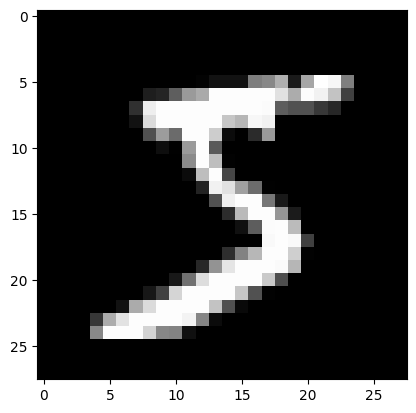

In [13]:
import matplotlib.pyplot as plt

with tf.device("CPU:0"):
    cpu_model = build_model(allow_cudnn_kernel=True)
    cpu_model.set_weights(model.get_weights())
    result = tf.argmax(cpu_model.predict_on_batch(tf.expand_dims(sample, 0)), axis=1)
    print(
        "Predicted result is: %s, target result is: %s" % (result.numpy(), sample_label)
    )
    plt.imshow(sample, cmap=plt.get_cmap("gray"))

## 支持列表/字典输入或嵌套输入的 RNN

实现器可以通过嵌套结构在单个时间步骤内包含更多信息。例如，一个视频帧可以同时包含音频和视频输入。在这种情况下，数据形状可以为：

`[batch, timestep, {"video": [height, width, channel], "audio": [frequency]}]`

在另一个示例中，手写数据可以包括笔的当前位置的 x 和 y 坐标，以及压力信息。因此，数据表示可以为：

`[batch, timestep, {"location": [x, y], "pressure": [force]}]`

以下代码提供了一个示例，演示了如何构建接受此类结构化输入的自定义 RNN 单元。

### 定义一个支持嵌套输入/输出的自定义单元

有关自行编写层的详细信息，请参阅[通过子类化创建新层和模型](https://tensorflow.google.cn/guide/keras/custom_layers_and_models/)。

In [14]:
class NestedCell(keras.layers.Layer):
    def __init__(self, unit_1, unit_2, unit_3, **kwargs):
        self.unit_1 = unit_1
        self.unit_2 = unit_2
        self.unit_3 = unit_3
        self.state_size = [tf.TensorShape([unit_1]), tf.TensorShape([unit_2, unit_3])]
        self.output_size = [tf.TensorShape([unit_1]), tf.TensorShape([unit_2, unit_3])]
        super(NestedCell, self).__init__(**kwargs)

    def build(self, input_shapes):
        # expect input_shape to contain 2 items, [(batch, i1), (batch, i2, i3)]
        i1 = input_shapes[0][1]
        i2 = input_shapes[1][1]
        i3 = input_shapes[1][2]

        self.kernel_1 = self.add_weight(
            shape=(i1, self.unit_1), initializer="uniform", name="kernel_1"
        )
        self.kernel_2_3 = self.add_weight(
            shape=(i2, i3, self.unit_2, self.unit_3),
            initializer="uniform",
            name="kernel_2_3",
        )

    def call(self, inputs, states):
        # inputs should be in [(batch, input_1), (batch, input_2, input_3)]
        # state should be in shape [(batch, unit_1), (batch, unit_2, unit_3)]
        input_1, input_2 = tf.nest.flatten(inputs)
        s1, s2 = states

        output_1 = tf.matmul(input_1, self.kernel_1)
        output_2_3 = tf.einsum("bij,ijkl->bkl", input_2, self.kernel_2_3)
        state_1 = s1 + output_1
        state_2_3 = s2 + output_2_3

        output = (output_1, output_2_3)
        new_states = (state_1, state_2_3)

        return output, new_states

    def get_config(self):
        return {"unit_1": self.unit_1, "unit_2": unit_2, "unit_3": self.unit_3}


### 使用嵌套输入/输出构建 RNN 模型

让我们构建一个使用 `keras.layers.RNN` 层和刚刚定义的自定义单元的 Keras 模型。

In [15]:
unit_1 = 10
unit_2 = 20
unit_3 = 30

i1 = 32
i2 = 64
i3 = 32
batch_size = 64
num_batches = 10
timestep = 50

cell = NestedCell(unit_1, unit_2, unit_3)
rnn = keras.layers.RNN(cell)

input_1 = keras.Input((None, i1))
input_2 = keras.Input((None, i2, i3))

outputs = rnn((input_1, input_2))

model = keras.models.Model([input_1, input_2], outputs)

model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])

### 使用随机生成的数据训练模型

由于此模型没有合适的候选数据集，我们使用随机 Numpy 数据进行演示。

In [16]:
input_1_data = np.random.random((batch_size * num_batches, timestep, i1))
input_2_data = np.random.random((batch_size * num_batches, timestep, i2, i3))
target_1_data = np.random.random((batch_size * num_batches, unit_1))
target_2_data = np.random.random((batch_size * num_batches, unit_2, unit_3))
input_data = [input_1_data, input_2_data]
target_data = [target_1_data, target_2_data]

model.fit(input_data, target_data, batch_size=batch_size)

 1/10 [==>...........................] - ETA: 9s - loss: 1.1592 - rnn_1_loss: 0.3051 - rnn_1_1_loss: 0.8541 - rnn_1_accuracy: 0.0781 - rnn_1_1_accuracy: 0.0297

 4/10 [===========>..................] - ETA: 0s - loss: 0.8706 - rnn_1_loss: 0.2863 - rnn_1_1_loss: 0.5843 - rnn_1_accuracy: 0.0898 - rnn_1_1_accuracy: 0.0320

 7/10 [====================>.........] - ETA: 0s - loss: 0.7861 - rnn_1_loss: 0.2685 - rnn_1_1_loss: 0.5175 - rnn_1_accuracy: 0.1004 - rnn_1_1_accuracy: 0.0304

10/10 [==============================] - ETA: 0s - loss: 0.7130 - rnn_1_loss: 0.2484 - rnn_1_1_loss: 0.4646 - rnn_1_accuracy: 0.1063 - rnn_1_1_accuracy: 0.0312

10/10 [==============================] - 1s 20ms/step - loss: 0.7130 - rnn_1_loss: 0.2484 - rnn_1_1_loss: 0.4646 - rnn_1_accuracy: 0.1063 - rnn_1_1_accuracy: 0.0312


使用 Keras `keras.layers.RNN` 层，您只需定义序列内单个步骤的数学逻辑，`keras.layers.RNN` 层将为您处理序列迭代。您可以通过这种异常强大的方式快速为新型 RNN（如 LSTM 变体）设计原型。

有关详情，请访问 [API 文档](https://https://tensorflow.google.cn/api_docs/python/tf/keras/layers/RNN/)。